# Problem 1 - Steganalysis

First, switch to GPU.

In steganaylsis (detecting steganography) it is often useful to start training the network with a 'pair-constraint', which means that we ensure there is a cover image (carrying no secret message) and its corresponding stego image (carrying secret message) in the same mini-batch. It was observed that without pair-constraint, many architectures won't start learning anything useful. 

Creating custom preprocessing of data might be of course useful in many other applications, so in this problem we will design a custom preprocessing pipeline with a pair-constraint using ```tf.data.Dataset```.

## 1.1 Detecting J-UNIWARD with EfficientNet-B0
You are provided with a dataset consisting of cover images and corresponding stego images (embedded with J-UNIWARD algorithm).

1. Finish the ```transforms_train``` function to randomly perform 
  * rotation by multiple of 90 degrees
  * horizontal flip
  * vertical flip

2. Load names of the cover and stego images. Create ```tf.data.Dataset``` objects from these names and create a new ```Dataset``` consisting of pairs ```(cover_path, stego_path)```, so that we can use it for generating batches with pair-constraint. The rest of the pipeline is already implemented.

3.  Take a batch from the training dataset (32 cover-stego pairs) and show from it
  * 5 cover images 
  * corresponding stego images 
  * differences between them, scale these into range ```[0,1]``` for better visualization

4. Define EfficientNet-B0 model and load the provided weights 'pretrained_B0_weights' (those are weights from a model trained on a simpler steganographic task)

5. Use a learning rate finder to get and idea of what LR to use. Use 1 epoch only.
  * Plot loss as a function of LR
  * Plot changes in loss as a function of LR

6. Train the model
  * Use OneCycle LR scheduler
  * Use 64 images in a batch
  * Train for 2 epochs
  * The accuracy won't be good


## 1.2 Reverse JPEG Compatibility Attack
Neural networks are powerful, but they are not necessarily doing the best job. To demonstrate that we will implement so-called Reverse JPEG compatibility attack. This attack works on jpeg images of high quality and all the images from our dataset have the highest quality, so it should be fine. 

The idea is very simple. instead of training on decompressed jpeg images $[I]$ where $[\cdot ]$ is rounding towards nearest integer (note that every standard library returns integer values after decompressing jpeg image), we will decompress from DCT coefficients ourself (scripts are provided) into floats $I$ and train on rounding errors $I-[I]$.

1. Take a batch from the training dataset and show
  * 5 cover inputs
  * histograms of these cover inputs, use 100 bins
  * histograms of corresponding stego inputs, use 100 bins

2. Train efficient-B0 (without ImageNet pretraining) on the rounding errors. Use the same hyperparameters (including the OneCycle scheduler) as in the first problem.
  * Comment



In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from scipy import fftpack
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
import numpy as np
import os
!pip install --quiet -U git+https://github.com/qubvel/efficientnet
!pip install --quiet -U git+https://github.com/albumentations-team/albumentations
!pip install --quiet -U git+https://github.com/dwgoon/jpegio
!pip install --quiet -U git+https://github.com/surmenok/keras_lr_finder
import efficientnet.keras as efn 
import albumentations as A
import jpegio as jio
from keras_lr_finder import LRFinder

     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 952kB 9.2MB/s 


In [ ]:
# download OneCycle functions
url = 'https://drive.google.com/uc?id=1riDdo8dKo9m-ATROwMZ7MKN1uFvLW-H8'
!gdown {url}
from onecycle import *

Downloading...
From: https://drive.google.com/uc?id=1riDdo8dKo9m-ATROwMZ7MKN1uFvLW-H8
To: /content/onecycle.py
100% 3.85k/3.85k [00:00<00:00, 3.18MB/s]


In [ ]:
# download and pretrained weights
url = 'https://drive.google.com/uc?id=1IAMNU9rtZha25DdXX3ckWif1VIs_5Lp0'
!gdown {url}
!unzip -q pretrained_B0_weights.zip
!rm pretrained_B0_weights.zip
pretrained_ckpt = '/content/pretrained_B0_weights'

Downloading...
From: https://drive.google.com/uc?id=1IAMNU9rtZha25DdXX3ckWif1VIs_5Lp0
To: /content/pretrained_B0_weights.zip
45.1MB [00:00, 73.3MB/s]


In [ ]:
# download and unzip the dataset
url = 'https://drive.google.com/uc?id=1oX5MIpM57RzNrbrXhwdGaMtJWDXXc1Fj'
!gdown {url}
!unzip -q stego_data.zip
!rm stego_data.zip
data_dir = '/content/stego_data/'

Downloading...
From: https://drive.google.com/uc?id=1oX5MIpM57RzNrbrXhwdGaMtJWDXXc1Fj
To: /content/stego_data.zip
1.21GB [00:12, 96.0MB/s]


In [ ]:
IMG_SIZE = (256,256)
EPOCHS = 2
BATCH_SIZE = 64
BUFFER_SIZE = 400
COVER_DIR = data_dir + 'Cover/'
STEGO_DIR = data_dir + 'JUNIWARD/'
AUTOTUNE = tf.data.experimental.AUTOTUNE

## 1.1 Detecting J-UNIWARD with EfficientNet-B0

In [ ]:
# 1. 
transforms_train = A.Compose([
      A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
      ### YOUR CODE HERE
      #
      #
      A.RandomRotate90(),
      #A.augmentations.transforms.RandomRotate90(always_apply=False, p=0.5),
      #ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
      #A.augmentations.transforms.VerticalFlip(always_apply=False, p=0.5),
      #A.augmentations.transforms.HorizontalFlip(always_apply=False, p=0.5),
      #Flip either vertical or horizontal
      A.HorizontalFlip(),
      A.VerticalFlip()
      #A.augmentations.transforms.Flip(always_apply=False,p=0.5)
      #
      #
  ], p=1.0, additional_targets={'image2': 'image'})

In [ ]:
transforms_val = A.Compose([
      A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1.0),
  ], p=1.0, additional_targets={'image2': 'image'})

def aug_fn(cover, stego, train):
  data = {"image": cover, "image2": stego}
  if train:
    data = transforms_train(**data)
  else:
    data = transforms_val(**data)
  cover = data["image"]
  stego = data["image2"]
  aug_pair = np.stack([cover,stego], axis=0)
  return aug_pair

def load_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image /= 255
  return image

def parse(cover_path, stego_path):
  cover = load_image(cover_path)
  stego = load_image(stego_path)
  
  label_cover = tf.one_hot(0, 2)
  label_stego = tf.one_hot(1, 2)
  label = tf.stack([label_cover, label_stego], axis=0)
  return cover, stego, label

def process_data_train(cover, stego, label):
  aug_pair = tf.numpy_function(func=aug_fn, inp=[cover, stego, True], 
                              Tout=tf.float32)
  return aug_pair, label

def process_data_val(cover, stego, label):
  aug_pair = tf.numpy_function(func=aug_fn, inp=[cover, stego, False], 
                              Tout=tf.float32)
  return aug_pair, label

In [ ]:
COVER_DIR_TRAIN_PATH = COVER_DIR + 'train/'
COVER_DIR_VAL_PATH = COVER_DIR + 'val/'
COVER_DIR_TRAIN = os.listdir(COVER_DIR_TRAIN_PATH)
COVER_DIR_VAL = os.listdir(COVER_DIR_VAL_PATH)

STEGO_DIR_TRAIN_PATH = STEGO_DIR + 'train/'
STEGO_DIR_VAL_PATH = STEGO_DIR + 'val/'
STEGO_DIR_TRAIN = os.listdir(STEGO_DIR_TRAIN_PATH)
STEGO_DIR_VAL = os.listdir(STEGO_DIR_VAL_PATH)


In [ ]:
# 2.
### YOUR CODE HERE 
cover_train_names = [COVER_DIR_TRAIN_PATH + x for x in COVER_DIR_TRAIN]
stego_train_names = [STEGO_DIR_TRAIN_PATH + x for x in STEGO_DIR_TRAIN]
cover_val_names = [COVER_DIR_VAL_PATH + x for x in COVER_DIR_VAL]
stego_val_names = [STEGO_DIR_VAL_PATH + x for x in STEGO_DIR_VAL]

# convert lists into tf.data.Dataset objects
cover_train = tf.data.Dataset.from_tensor_slices(cover_train_names)
stego_train = tf.data.Dataset.from_tensor_slices(stego_train_names)
# create cover-stego pairs
train_names = tf.data.Dataset.from_tensor_slices((cover_train_names, stego_train_names))

# similarly for validation data
cover_val = tf.data.Dataset.from_tensor_slices(cover_val_names)
stego_val = tf.data.Dataset.from_tensor_slices(stego_val_names)
val_names = tf.data.Dataset.from_tensor_slices((cover_val_names, stego_val_names))
###           

In [ ]:
# process pairs and batch them
data_train = train_names.shuffle(buffer_size = BUFFER_SIZE).map(parse, 
                  num_parallel_calls=AUTOTUNE).map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE//2,drop_remainder=True)
# need to define shape after calling a python function
# and change shape from (B/2,2,H,W,3) into (B,H,W,3)                  
data_train = data_train.map(lambda x,y:
                  (tf.reshape(x, (BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3)), 
                   tf.reshape(y, (BATCH_SIZE, 2)))).prefetch(AUTOTUNE)

data_val = train_names.map(parse, 
                  num_parallel_calls=AUTOTUNE).map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE//2, drop_remainder=True)
data_val = data_val.map(lambda x,y:
                  (tf.reshape(x, (BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3)), 
                   tf.reshape(y, (BATCH_SIZE, 2)))).prefetch(AUTOTUNE)       

[1 0]


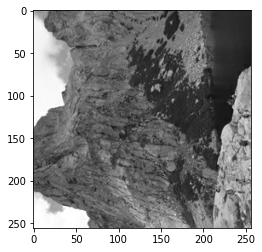

[0 1]


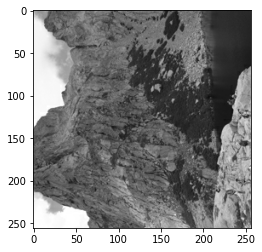

Difference :


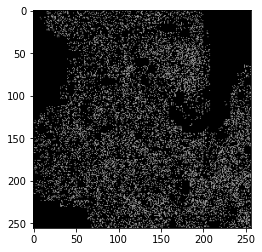

[1 0]


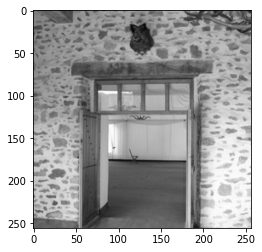

[0 1]


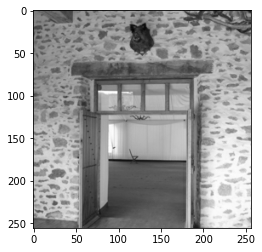

Difference :


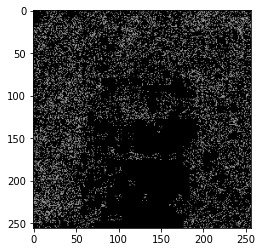

[1 0]


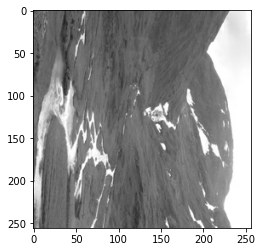

[0 1]


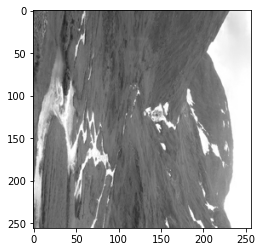

Difference :


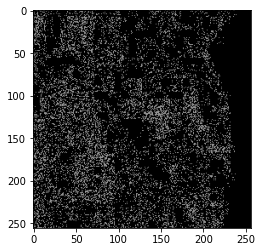

[1 0]


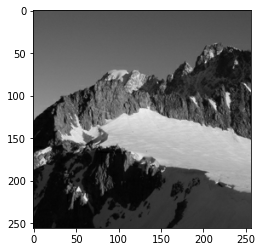

[0 1]


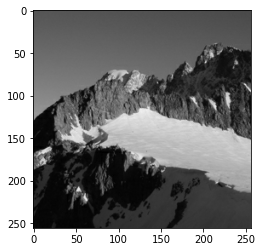

Difference :


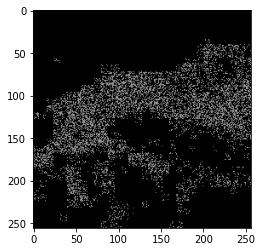

[1 0]


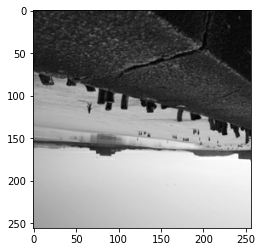

[0 1]


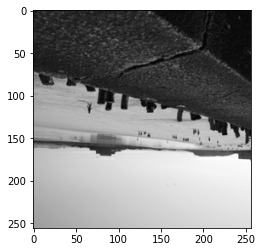

Difference :


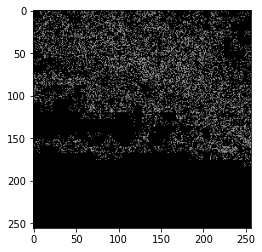

In [ ]:
images, labels = next(iter(data_train))
#images = images*0.5 + 0.5
x = images[0]
y = images[1]

### YOUR CODE HERE
for i in range(10):
  if tf.keras.backend.get_value(labels[i][0]==1 and labels[i][1]==0):               
    x = images[i]
    tf.print(labels[i])
    plt.imshow(x)
    plt.show()

  else:
    y = images[i]
    tf.print(labels[i])
    plt.imshow(y)
    plt.show()
    print("Difference :")
    z = tf.math.abs(tf.math.subtract(x, y))
    #z = tf.math.scalar_mul(100,tf.math.abs(tf.math.subtract(x, y)))
    z = tf.keras.utils.normalize(z)
    plt.imshow(z)
    plt.show()
 

In [ ]:
# define pretrained EfficientNet-B0
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(2)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 8, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# import 'pretrained_B0_weights' and initialized the model with them
model.load_weights(pretrained_ckpt)
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Please use Model.fit, which supports generators.
437/437 [==============================] - 8790s 20s/step - loss: 1.5742 - accuracy: 0.5719


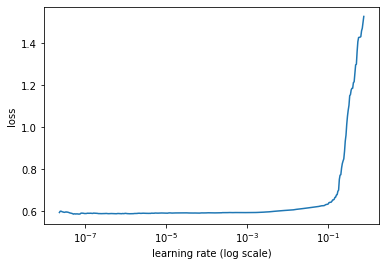

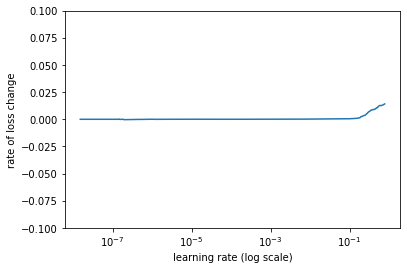

1.9942114e-07

In [ ]:
# 5.
### YOUR CODE HERE
lr_finder = LRFinder(model)
lr_finder.find_generator(data_train, start_lr=1e-8, end_lr=1, epochs=1)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
lr_finder.plot_loss_change(sma=BATCH_SIZE, y_lim=(-0.1,0.1))
lr_finder.get_best_lr(BATCH_SIZE)

In [ ]:
MAX_LR = 1.48e-07
TRN_SIZE = 5000

In [ ]:
# 6. define onecycle LR callback and train the model
### YOUR CODE HERE
NUM_EPOCH = 2
steps = np.ceil(TRN_SIZE / BATCH_SIZE) * NUM_EPOCH
lr_schedule = OneCycleScheduler(MAX_LR, steps)
###

In [ ]:
model.fit(x=data_train, validation_data=data_val, epochs=2, callbacks=[lr_schedule])

## 1.2 Reverse JPEG compatibility

In [ ]:
# functions for decompressing jpeg structure into an image
def block_view(A, block=(8,8)):
  shape = (A.shape[0]//block[0], A.shape[1]//block[1]) + block
  strides = (block[0]*A.strides[0], block[1]*A.strides[1]) + A.strides
  return as_strided(A, shape=shape, strides=strides)

def segmented_stride(M, fun, blk_size=(8,8), overlap=(0,0)):
  B = block_view(M, block=blk_size)
  B[:,:,:,:] = fun(B)
  return M

def decompress_structure(S):
  H = S.coef_arrays[0].shape[0]
  W = S.coef_arrays[0].shape[1]
  n = len(S.coef_arrays)
  assert H%8 == 0, 'Wrong image size'
  assert W%8 == 0, 'Wrong image size'
  I = np.zeros((H,W,n), dtype=np.float64) # Return Y,Cb,Cr
  for i in range(n):
    Q = S.quant_tables[S.comp_info[i].quant_tbl_no]
    fun = lambda x: np.multiply(x, Q)
    C = np.float64(segmented_stride(S.coef_arrays[i], fun))
    fun = lambda x: fftpack.idct(fftpack.idct(x, norm='ortho', axis=2), norm='ortho', axis=3) + 128
    I[:,:,i] = segmented_stride(C, fun)
  return I

def load_error(path):
  jpeg_struct = jio.read(path.numpy().decode('utf-8'))
  I = decompress_structure(jpeg_struct).astype(np.float32)
  I = I - np.round(I) # compute the rounding error
  I = np.repeat(I, 3, -1) # turn grayscale into 3-channel input
  # I /= 255 # we don't have to scale the input because it is already bounded in (-0.5,0.5)
  I = tf.convert_to_tensor(I, dtype=tf.float32)
  return I

def parse_error(cover_path, stego_path):
  I_cover = load_error(cover_path)
  I_stego = load_error(stego_path)

  label_cover = tf.one_hot(0, 2)
  label_stego = tf.one_hot(1, 2)
  label = tf.stack([label_cover, label_stego], axis=0)

  return I_cover, I_stego, label

In [ ]:
# Reuse the train_names and val_names from first part of the problem
data_train = train_names.shuffle(buffer_size = BUFFER_SIZE).map(lambda x,y: 
                  tf.py_function(parse_error, [x,y], [tf.float32, tf.float32, tf.float32]),
                  num_parallel_calls=AUTOTUNE).map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE//2, drop_remainder=True)
data_train = data_train.map(lambda x,y:
                  (tf.reshape(x, (BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3)), 
                   tf.reshape(y, (BATCH_SIZE, 2)))).prefetch(AUTOTUNE)

data_val = train_names.map(lambda x,y: 
                  tf.py_function(parse_error, [x,y], [tf.float32, tf.float32, tf.float32]),
                  num_parallel_calls=AUTOTUNE).map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE//2, drop_remainder=True)
data_val = data_val.map(lambda x,y:
                  (tf.reshape(x, (BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3)), 
                   tf.reshape(y, (BATCH_SIZE, 2)))).prefetch(AUTOTUNE)       

In [ ]:
# 1.
images, labels = next(iter(data_train))
x = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
for i in range(10):
  if tf.keras.backend.get_value(labels[i][0]==1 and labels[i][1]==0):               
    x = images[i]
    bins =100
    
    plt.subplot(5,2,i+1)
    plt.title("Cover")
    plt.hist(np.array(x).flatten(), density = True, bins=100)
    plt.show()
  else:
    plt.style.use('ggplot')
    y = images[i]
    plt.subplot(5,2,i+1)
    plt.title("Stego")
    plt.hist(np.array(y).flatten(), density = True, bins=100)
    plt.show()

In [ ]:
# define EfficientNet without any pretraining
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights=None, include_top=False)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(2)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# If you don't have the lr schedule in previous part, skip this. 
# Otherwise just copy the code
NUM_EPOCH = 2
steps = np.ceil(BUFFER_SIZE / BATCH_SIZE) * NUM_EPOCH
lr_schedule = OneCycleScheduler(MAX_LR, steps)

The training will be a little slower because of the custom python preprocessing

In [ ]:
# train the model
model.fit(x=data_train, validation_data=data_val, epochs=2, callbacks=[lr_schedule])

#2 - Comment
The Accuracy had improve significantly because of the JPEG compability algorithm. The JPEG algorithm applies the discrete Cosine transform to an 8x8 images block. The Discrete Cosine Transform atenuates or eleminates higher frequencies from the images, because higher frequencies contribute less to the information of the image. Also,the JPEG compression algorithm leaves unique fingerprints and enable us to detect small pixel changes . The detection of such changes is based on investigating the compatibility of 8×8 blocks of pixels with JPEG compression with a given quantization matrix.


EfficientNet BO perform Compound Scaling, which scales all three dimensions of an image input, while mantaining a balance between all dimensions of the network. This increases the accuracy when training the model.

Sources : 
https://amaarora.github.io/2020/08/13/efficientnet.html
https://www.blackhat.com/docs/asia-14/materials/Ortiz/Asia-14-Ortiz-Advanced-JPEG-Steganography-And-Detection.pdf
